Optimization terminated successfully.
         Current function value: 0.609131
         Iterations 7
Area under the ROC curve : 0.760101
Optimization terminated successfully.
         Current function value: 0.615751
         Iterations 7
0.7217484008528785


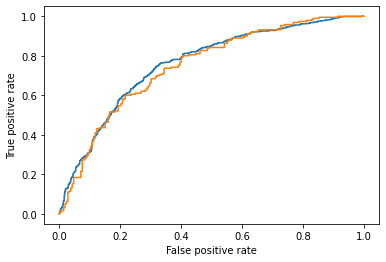

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split # train and test 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

#Importing Data
claimants = pd.read_csv("claimants.csv", sep = ",")

# Removing CASENUM
c1 = claimants.drop('CASENUM', axis = 1)
c1.head(11)
c1.describe()
c1.isna().sum()

# To drop NaN values
df = claimants.dropna()

# Imputating the missing values           
# Mean Imputation - CLMAGE is a continuous data

mean_value = c1.CLMAGE.mean()
mean_value
c1.CLMAGE = c1.CLMAGE.fillna(mean_value)
c1.CLMAGE.isna().sum()

# For Median imputation try this
# median_value = claimants.CLMAGE.median()
# claimants1['CLMAGE'] = claimants1['CLMAGE'].fillna(median_value)


# For Mode - for Discrete variables
# CLMSEX
mode_CLMSEX = c1.CLMSEX.mode()
mode_CLMSEX
c1.CLMSEX = c1.CLMSEX.fillna((mode_CLMSEX)[0])
c1.CLMSEX.isna().sum()

# CLMINSUR
mode_INSUR = c1['CLMINSUR'].mode()
mode_INSUR
c1['CLMINSUR'] = c1['CLMINSUR'].fillna((mode_INSUR)[0])
c1.CLMINSUR.isna().sum()

# SEATBELT
mode_SB = c1['SEATBELT'].mode()
mode_SB
c1['SEATBELT'] = c1['SEATBELT'].fillna((mode_SB)[0])
c1.SEATBELT.isna().sum()

# Alternate approach
########## Median Imputation for all the columns ############
c1.fillna(c1.median(), inplace=True)
c1.isna().sum()

c1.CLMAGE.median()
c1.CLMINSUR.median()
#############################################################

# Model building 
# import statsmodels.formula.api as sm
logit_model = sm.logit('ATTORNEY ~ CLMAGE + LOSS + CLMINSUR + CLMSEX + SEATBELT', data = c1).fit()

#summary
logit_model.summary()
logit_model.summary2() # for AIC


pred = logit_model.predict(c1.iloc[ :, 1: ])

# from sklearn import metrics
fpr, tpr, thresholds = roc_curve(c1.ATTORNEY, pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

# import pylab as pl

i = np.arange(len(tpr))
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
# roc.iloc[(roc.tf-0).abs().argsort()[:1]]


#ROC CURVE AND AUC
#PLOT OF ROC
plt.plot(fpr, tpr);plt.xlabel("False positive rate");plt.ylabel("True positive rate")


# Plot 1-fpr vs tpr
# fig, ax = pl.subplots()
# pl.plot(roc['1-fpr'], color = 'blue')
# pl.plot(roc['tpr'], color = 'red')
# pl.xlabel('1-False Positive Rate')
# pl.ylabel('True Positive Rate')
# pl.title('Receiver operating characteristic')
# ax.set_xticklabels([])

roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# filling all the cells with zeroes
c1["pred"] = np.zeros(1340)
# taking threshold value and above the prob value will be treated as correct value 
c1.loc[pred > optimal_threshold, "pred"] = 1

# classification report
classification = classification_report(c1["pred"], c1["ATTORNEY"])
classification


### Splitting the data into train and test data 
# from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(c1, test_size = 0.3) # 30% test data

# Model building 
# import statsmodels.formula.api as sm
model = sm.logit('ATTORNEY ~ CLMAGE + LOSS + CLMINSUR + CLMSEX + SEATBELT', data = train_data).fit()

#summary
model.summary2() # for AIC
model.summary()

# Prediction on Test data set
test_pred = model.predict(test_data)

# Creating new column for storing predicted class of Attorney
# filling all the cells with zeroes
test_data["test_pred"] = np.zeros(402)

# taking threshold value as 'optimal_threshold' and above the thresold prob value will be treated as 1 
test_data.loc[test_pred > optimal_threshold, "test_pred"] = 1

# confusion matrix 
confusion_matrix = pd.crosstab(test_data.test_pred, test_data['ATTORNEY'])
confusion_matrix

accuracy_test = (129 + 147)/(402) 
accuracy_test

# classification report
classification_test = classification_report(test_data["test_pred"], test_data["ATTORNEY"])
classification_test

#ROC CURVE AND AUC
fpr, tpr, threshold = metrics.roc_curve(test_data["ATTORNEY"], test_pred)

#PLOT OF ROC
plt.plot(fpr, tpr);plt.xlabel("False positive rate");plt.ylabel("True positive rate")

roc_auc_test = metrics.auc(fpr, tpr)
roc_auc_test


# prediction on train data
train_pred = model.predict(train_data.iloc[ :, 1: ])

# Creating new column 
# filling all the cells with zeroes
train_data["train_pred"] = np.zeros(938)

# taking threshold value and above the prob value will be treated as correct value 
train_data.loc[train_pred > optimal_threshold, "train_pred"] = 1

# confusion matrix
confusion_matrx = pd.crosstab(train_data.train_pred, train_data['ATTORNEY'])
confusion_matrx

accuracy_train = (338 + 339)/(938)
print(accuracy_train)


In [2]:
c1.fillna(c1.median(), inplace=True)
c1.isna().sum()

ATTORNEY    0
CLMSEX      0
CLMINSUR    0
SEATBELT    0
CLMAGE      0
LOSS        0
pred        0
dtype: int64

In [3]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ATTORNEY   No. Observations:                 1340
Model:                          Logit   Df Residuals:                     1334
Method:                           MLE   Df Model:                            5
Date:                Sun, 25 Sep 2022   Pseudo R-squ.:                  0.1209
Time:                        07:41:37   Log-Likelihood:                -816.24
converged:                       True   LL-Null:                       -928.48
Covariance Type:            nonrobust   LLR p-value:                 1.620e-46
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1493      0.226     -0.660      0.509      -0.592       0.294
CLMAGE         0.0066      0.003      2.058      0.040       0.000       0.013
LOSS          -0.3228      0.029    -10.962      0.000      -0.381      -0.265
CLMINSUR       0.5284      0.210      2.516      0.012       0.117       0.940
CLMSEX         0.3204      0.120      2.674      0.008       0.086       0.555
SEATBELT      -0.6718      0.522     -1.286      0.198      -1.696       0.352
==============================================================================
"""

In [4]:
logit_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.121     
Dependent Variable: ATTORNEY         AIC:              1644.4709 
Date:               2022-09-25 07:42 BIC:              1675.6734 
No. Observations:   1340             Log-Likelihood:   -816.24   
Df Model:           5                LL-Null:          -928.48   
Df Residuals:       1334             LLR p-value:      1.6204e-46
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept    -0.1493    0.2260   -0.6604  0.5090  -0.5922   0.2937
CLMAGE        0.0066    0.0032    2.0583  0.0396   0.0003   0.0128
LOSS         -0.3228    0.0294  -10.9615  0.0000  -0.3805  -0.2651
CLMINSUR      0.5284    0.2100    2.5159  0.0119   0.1168   0.9400
CLMSEX        0.3204    0.1198    2.6736  0.0075   0.0855   0.5552
SEATBELT     -0.6718    0.5224   -1.2860  0.1984  -1.6958   0.3521
=================================================================

"""

In [5]:
pred

0       0.000026
1       0.500422
2       0.575767
3       0.474743
4       0.637341
          ...   
1335    0.593816
1336    0.451543
1337    0.715776
1338    0.309620
1339    0.662483
Length: 1340, dtype: float64

In [7]:
pred

0       0.000026
1       0.500422
2       0.575767
3       0.474743
4       0.637341
          ...   
1335    0.593816
1336    0.451543
1337    0.715776
1338    0.309620
1339    0.662483
Length: 1340, dtype: float64

In [8]:
c1

,ATTORNEY,CLMSEX,CLMINSUR,SEATBELT,CLMAGE,LOSS,pred
0,0,0.0,1.0,0.0,50.000000,34.940,0.0
1,1,1.0,0.0,0.0,18.000000,0.891,1.0
2,1,0.0,1.0,0.0,5.000000,0.330,1.0
3,0,0.0,1.0,1.0,31.000000,0.037,0.0
4,1,0.0,1.0,0.0,30.000000,0.038,1.0
...,...,...,...,...,...,...,...
1335,1,0.0,1.0,0.0,28.414422,0.576,1.0
1336,0,1.0,1.0,0.0,46.000000,3.705,0.0
1337,1,1.0,1.0,0.0,39.000000,0.099,1.0
1338,0,1.0,0.0,0.0,8.000000,3.177,0.0


In [9]:
classification

'              precision    recall  f1-score   support\n\n         0.0       0.64      0.74      0.69       587\n         1.0       0.77      0.67      0.72       753\n\n    accuracy                           0.70      1340\n   macro avg       0.70      0.71      0.70      1340\nweighted avg       0.71      0.70      0.70      1340\n'

Text(0, 0.5, 'True positive rate')

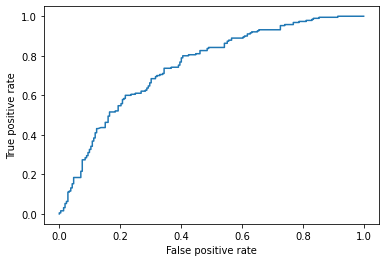

In [11]:
plt.plot(fpr, tpr);plt.xlabel("False positive rate");plt.ylabel("True positive rate")


In [12]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.6632562101955198

In [13]:
optimal_idx

102

Text(0, 0.5, 'True positive rate')

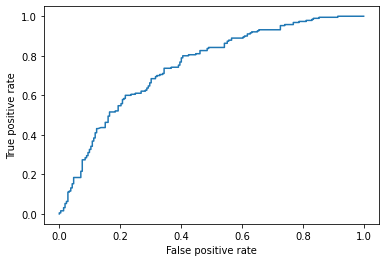

In [14]:
plt.plot(fpr, tpr);plt.xlabel("False positive rate");plt.ylabel("True positive rate")


In [ ]:
roc_auc

In [15]:
confusion_matrix

ATTORNEY,0,1
test_pred,,
0.0,138,50
1.0,74,140


In [16]:
accuracy_test

0.6865671641791045

In [17]:
roc_auc_test

0.748286991062562